## Lower Data preprocessing

Only Extracts and smoother lower body joint coordinates for specific analysis metrics.


#### Define Imports and Settings
Defines imports and constants to tune preprocessing settings

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# Dataset Paths
INPUT_PATH = "data/raw/12.12_raw.csv"
OUT_PATH = "data/preprocessed/12.12_lowerBody.csv"


# PARAMETERS
MAX_JUMP = 1.0          # meters per frame (catastrophic failure guard)
SMOOTH_WINDOW = 3       # odd number, light smoothing

# ---- DEFINE LOWER BODY JOINTS EXPLICITLY ----
# ⚠️ ADJUST THESE INDICES TO MATCH YOUR SKELETON
LOWER_BODY_JOINTS = {
    "left_hip": 23,
    "right_hip": 24,
    "left_knee": 25,
    "right_knee": 26,
    "left_ankle": 27,
    "right_ankle": 28,
    "left_heel": 29,
    "right_heel": 30
}

# For Quick Lookup
TEST_JOINT = JOINT_IDS[29]

# Time window for test lookup
START = 1000
END = 1500


# VISUALIZATION PARAMS
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

# Set Seaborn theme
sns.set_theme(
    style="white",
    context="notebook",
    rc={
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "legend.frameon": False,})

#### Overview
Read dataset and quick lookup

In [110]:
df = pd.read_csv(INPUT_PATH)

print("Total frames:", len(df))
print("Total columns:", len(df.columns))

def detect_joints(columns):
    joints = set()
    for c in columns:
        if c.startswith("joint_") and "_x" in c:
            idx = c.split("_")[1]
            joints.add(int(idx))
    return sorted(joints)

JOINT_IDS = detect_joints(df.columns)
NUM_JOINTS = len(JOINT_IDS)

print("Detected joints:", JOINT_IDS)
print("Number of joints:", NUM_JOINTS)

Total frames: 23819
Total columns: 166
Detected joints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Number of joints: 33


#### Handle timestamps
Turns ISO format timestamps to seconds. Extracts timing information

In [111]:
# Parse timestamps
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Convert to seconds since start
t0 = df["timestamp"].iloc[0]
df["time_s"] = (df["timestamp"] - t0).dt.total_seconds()

# Frame intervals
dt = np.diff(df["time_s"])
fps_est = 1.0 / np.median(dt)

print(f"Estimated FPS: {fps_est:.2f}")
print(f"Mean dt: {np.mean(dt):.4f} s")
print(f"Std dt: {np.std(dt):.4f} s")

Estimated FPS: 15.26
Mean dt: 0.0712 s
Std dt: 0.0503 s


#### Perform tests and Data Quality inspection
Inspect data. Useful to plan further steps

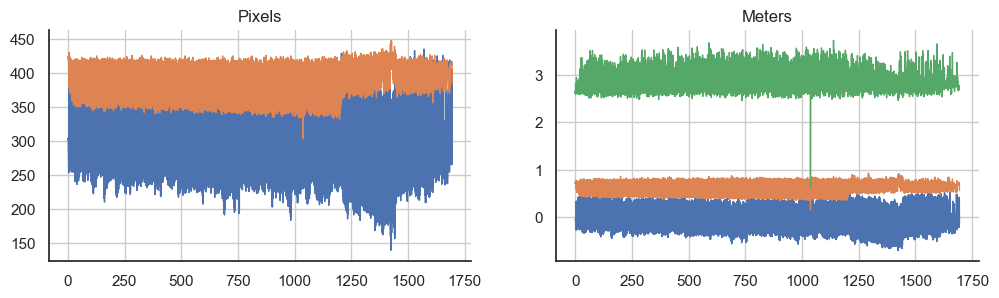

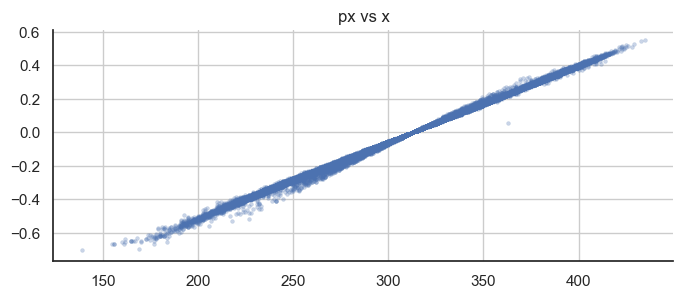

In [112]:
# Define Test Joints, Metric and Pixel
x = df[f"joint_{TEST_JOINT}_x"]
y = df[f"joint_{TEST_JOINT}_y"]
z = df[f"joint_{TEST_JOINT}_z"]

px = df[f"joint_{TEST_JOINT}_px"]
py = df[f"joint_{TEST_JOINT}_py"]


fig, ax = plt.subplots(1, 2, figsize=(12, 3), sharex=True)
sns.lineplot(x=t, y=px, ax=ax[0], lw=1)
sns.lineplot(x=t, y=py, ax=ax[0], lw=1)
ax[0].set_title("Pixels")
ax[0].set_xlabel("")
ax[0].set_ylabel("")

sns.lineplot(x=t, y=x, ax=ax[1], lw=1)
sns.lineplot(x=t, y=y, ax=ax[1], lw=1)
sns.lineplot(x=t, y=z, ax=ax[1], lw=1)
ax[1].set_title("Meters")
ax[1].set_xlabel("")
ax[1].set_ylabel("")

plt.figure(figsize=(8,3))
sns.scatterplot(x=px, y=x, s=8, alpha=0.3, edgecolor=None)
plt.title("px vs x")
plt.xlabel("")
plt.ylabel("")
plt.show()

#### Prepare Dataset
Only writes necessary data for lower body joint analysis.

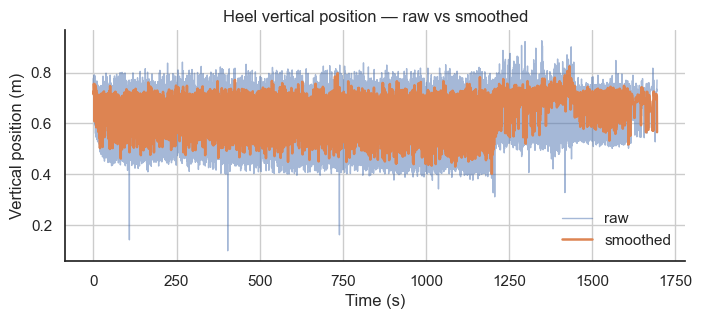

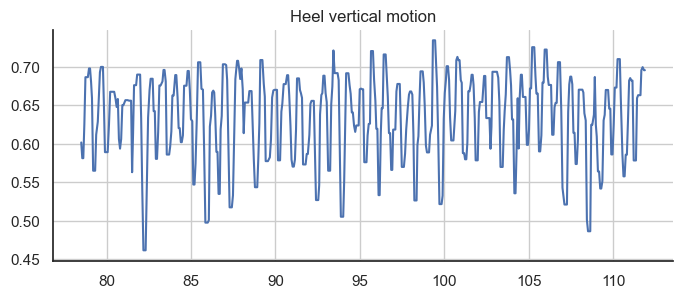

In [113]:
# PREPARE OUTPUT DATAFRAME
out = pd.DataFrame()
out["time_s"] = df["time_s"].to_numpy()

# PROCESS EACH LOWER BODY JOINT
for name, jid in LOWER_BODY_JOINTS.items():

    # ---- Extract raw coordinates ----
    x = df[f"joint_{jid}_x"].to_numpy().astype(float)
    y = df[f"joint_{jid}_y"].to_numpy().astype(float)
    z = df[f"joint_{jid}_z"].to_numpy().astype(float)

    # ---- Extract pixel coordinates (DO NOT TOUCH) ----
    px = df[f"joint_{jid}_px"].to_numpy().astype(float)
    py = df[f"joint_{jid}_py"].to_numpy().astype(float)

    # ---- Frame-to-frame 3D displacement ----
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])

    dpos = np.sqrt(dx**2 + dy**2 + dz**2)

    # ---- Kill physically impossible frames ----
    bad = (dpos > MAX_JUMP) | (z <= 0)

    x[bad] = np.nan
    y[bad] = np.nan
    z[bad] = np.nan

    # ---- Interpolate gaps (preserve time) ----
    x = pd.Series(x).interpolate(limit_direction="both").to_numpy()
    y = pd.Series(y).interpolate(limit_direction="both").to_numpy()
    z = pd.Series(z).interpolate(limit_direction="both").to_numpy()

    # ---- Smooth (metric only) ----
    x_s = medfilt(x, kernel_size=SMOOTH_WINDOW)
    y_s = medfilt(y, kernel_size=SMOOTH_WINDOW)
    z_s = medfilt(z, kernel_size=SMOOTH_WINDOW)

    # ---- Store ONLY smoothed lower-body coordinates ----
    out[f"{name}_x"] = x_s
    out[f"{name}_y"] = y_s
    out[f"{name}_z"] = z_s

    # ---- Store raw pixel coordinates ----
    out[f"{name}_px"] = px
    out[f"{name}_py"] = py

# Visualization of Smoothing. Adjust smoothing if change is harsh
plt.figure(figsize=(8,3))
sns.lineplot(x=t, y=y, lw=1, alpha=0.5, label="raw")
sns.lineplot(x=t, y=y_smooth, lw=1.8, label="smoothed")
plt.xlabel("Time (s)")
plt.ylabel("Vertical position (m)")
plt.title("Heel vertical position — raw vs smoothed")
plt.legend()

# ZOOMED VIEW (CHECK STEP OSCILLATIONS)
plt.figure(figsize=(8,3))
sns.lineplot(x=t[START:END], y=y_smooth[START:END], lw=1.5)
plt.xlabel("")
plt.ylabel("")
plt.title("Heel vertical motion")
plt.show()

#### Output
Save preprocessed data

In [114]:
# SAVE LOWER BODY DATASET
out.to_csv(OUT_PATH, index=False)

print(f"Saved lower-body dataset to: {OUT_PATH}")
print("Columns:", list(out.columns))

Saved lower-body dataset to: data/preprocessed/12.12_lowerBody.csv
Columns: ['time_s', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_px', 'left_hip_py', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_px', 'right_hip_py', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_px', 'left_knee_py', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_px', 'right_knee_py', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_px', 'left_ankle_py', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_px', 'right_ankle_py', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_px', 'left_heel_py', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_px', 'right_heel_py']
